In [1]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold,validation_curve,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVC

In [2]:
data_reg=pd.read_excel('data_reg.xlsx')
data_class=pd.read_excel('data_class.xlsx')
data_reg_prep=pd.read_excel('data_reg_prep.xlsx')
data_class_prep=pd.read_excel('data_class_prep.xlsx')

data_reg_temp = data_reg.drop("SalePrice",axis = 1)
cols_temp = ["OverallQual","OverallCond","IsRemodGar","IsRemod"]
data_reg_temp[cols_temp]=data_reg_temp[cols_temp].astype("object")

cat_cols = data_reg_temp.select_dtypes(include = "object").columns.tolist()
print(len(cat_cols))
print(cat_cols)

num_cols = data_reg_temp.select_dtypes(include="number").columns.tolist()
print(len(num_cols))
print(num_cols)

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data_reg_temp,data_reg["SalePrice"],test_size =0.3,random_state=0)
Xtrain = Xtrain.sort_index()
Xtest = Xtest.sort_index()
Ytrain= Ytrain.sort_index()
Ytest = Ytest.sort_index()

Xtrain_index = Xtrain.index.tolist()
Xtest_index = Xtest.index.tolist()

Xtrain_cat = Xtrain[cat_cols]

Xtrain_num = Xtrain[num_cols]
train_mean= Xtrain_num.mean()
train_std = np.sqrt(Xtrain_num.var())

Xtest_cat = Xtest[cat_cols]
Xtest_num = Xtest[num_cols]

Xtrain_num_std = Xtrain_num.apply(lambda x: (x - x.mean()) / np.sqrt(x.var())) 
Xtest_num_std = Xtest_num.copy()
for i in num_cols:
    Xtest_num_std[i] = (Xtest_num_std[i] - train_mean[i]) / train_std[i]

#axis = 0 caculate the mean or var through columns ,which is the default value in apply
# data_num_nor = data_num[numeric_cols].apply(lambda x: (x - x.min()) / (x.max(axis=0) - x.min(axis=0)))

#dummy的话最好一起dummy，因为有可能 test dataset 没有一些分类，导致train和test 的dummy的维度不一致

cat_dummy = data_reg_temp[cat_cols].copy()
for i in cat_cols:
    dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
    cat_dummy = pd.concat([cat_dummy,dummy_df], axis=1)
    cat_dummy = cat_dummy.drop(i, axis = 1)
print(cat_dummy.shape) 

Xtest_cat_dummy = cat_dummy.iloc[Xtest_index,:]
Xtrain_cat_dummy = cat_dummy.iloc[Xtrain_index,:]

Xtrain_lr = pd.concat((Xtrain_num_std,Xtrain_cat_dummy),axis = 1)
Xtest_lr = pd.concat((Xtest_num_std,Xtest_cat_dummy),axis = 1)
Ytrain_lr = Ytrain
Ytest_lr = Ytest

Xtrain_tree = pd.concat((Xtrain_num,Xtrain_cat),axis = 1)
Xtest_tree = pd.concat((Xtest_num,Xtest_cat),axis = 1)
Ytrain_tree = data_class.iloc[Xtrain_index,:]["PriceLevel"]
Ytest_tree = data_class.iloc[Xtest_index,:]["PriceLevel"]

20
['MSZoning', 'LotShape', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'MasVnrType', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition', 'IsRemodGar', 'IsRemod']
9
['LotArea', 'YearBuilt', 'MasVnrArea', 'Fireplaces', 'GarAreaPerCar', 'GrLivAreaPerRoom', 'TotalHouseSF', 'TotalFullBath', 'TotalPorchSF']
(2930, 125)


C:\Users\T480S\AppData\Local\Temp\ipykernel_10324\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_10324\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_10324\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_10324\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when pas

In [3]:
clf =SVC(kernel="linear").fit(Xtrain_lr,Ytrain_tree)
clf.predict(Xtest_lr)
print(clf.score(Xtest_lr,Ytest_tree))
print(clf.support_vectors_.shape)
print(clf.n_support_)

0.7929465301478953
(1072, 134)
[319 212 394 147]


In [5]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)

#parameters = {'kernel':["linear","poly","rbf","sigmoid"]
 #             }
parameters = {'kernel':["linear","rbf"]
             ,'gamma':np.logspace(-10, 1, 15)
             ,'C':np.linspace(0.05,2,10)}
SVM = SVC(cache_size=9000,probability=True)
GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtrain_lr, Ytrain_tree)
# GS_recall = GridSearchCV(SVM, parameters, cv=kf, scoring="recall_macro")
# GS_recall.fit(Xtrain_lr, Ytrain_tree)
# GS_roc = GridSearchCV(SVM, parameters, cv=kf, scoring="roc_auc_ovr")
# GS_roc.fit(Xtrain_lr, Ytrain_tree)

 
print(GS_acc.best_params_)
print(GS_acc.best_score_)

{'C': 1.1333333333333335, 'gamma': 0.04393970560760786, 'kernel': 'rbf'}
0.764503399419959


In [7]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)

#parameters = {'kernel':["linear","poly","rbf","sigmoid"]
 #             }
parameters = {'kernel':["rbf"]
             ,'gamma':[ 0.04393970560760786]
             ,'C':[1.1333333333333335]}
SVM = SVC(cache_size=9000,probability=True)
GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtrain_lr, Ytrain_tree)
GS_recall = GridSearchCV(SVM, parameters, cv=kf, scoring="recall_macro")
GS_recall.fit(Xtrain_lr, Ytrain_tree)
GS_roc = GridSearchCV(SVM, parameters, cv=kf, scoring="roc_auc_ovr")
GS_roc.fit(Xtrain_lr, Ytrain_tree)

 
print(GS_acc.best_params_)
print(GS_acc.best_score_)
print(GS_recall.best_params_)
print(GS_recall.best_score_)
print(GS_roc.best_params_)
print(GS_roc.best_score_)

GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtest_lr, Ytest_tree)


{'C': 1.1333333333333335, 'gamma': 0.04393970560760786, 'kernel': 'rbf'}
0.764503399419959
{'C': 1.1333333333333335, 'gamma': 0.04393970560760786, 'kernel': 'rbf'}
0.7651498190133112
{'C': 1.1333333333333335, 'gamma': 0.04393970560760786, 'kernel': 'rbf'}
0.9391079073837987


In [8]:
GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtest_lr, Ytest_tree)
print(GS_acc.best_params_)
print(GS_acc.best_score_)

{'C': 1.1333333333333335, 'gamma': 0.04393970560760786, 'kernel': 'rbf'}
0.7451568647753158


In [13]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)

#parameters = {'kernel':["linear","poly","rbf","sigmoid"]
 #             }
parameters = {'kernel':["rbf"]
             ,'gamma':[0.01,0.03,0.05]
             ,'C':np.linspace(0.1,1.5,12)}
SVM = SVC(cache_size=9000,probability=True)
GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtrain_lr, Ytrain_tree)
GS_recall = GridSearchCV(SVM, parameters, cv=kf, scoring="recall_macro")
GS_recall.fit(Xtrain_lr, Ytrain_tree)
GS_roc = GridSearchCV(SVM, parameters, cv=kf, scoring="roc_auc_ovr")
GS_roc.fit(Xtrain_lr, Ytrain_tree)

 
print(GS_acc.best_params_)
print(GS_acc.best_score_)

{'C': 1.3727272727272726, 'gamma': 0.03, 'kernel': 'rbf'}
0.7732869264425094


{'C': 1.373, 'gamma': 0.03, 'kernel': 'rbf'}
0.7766874369473621


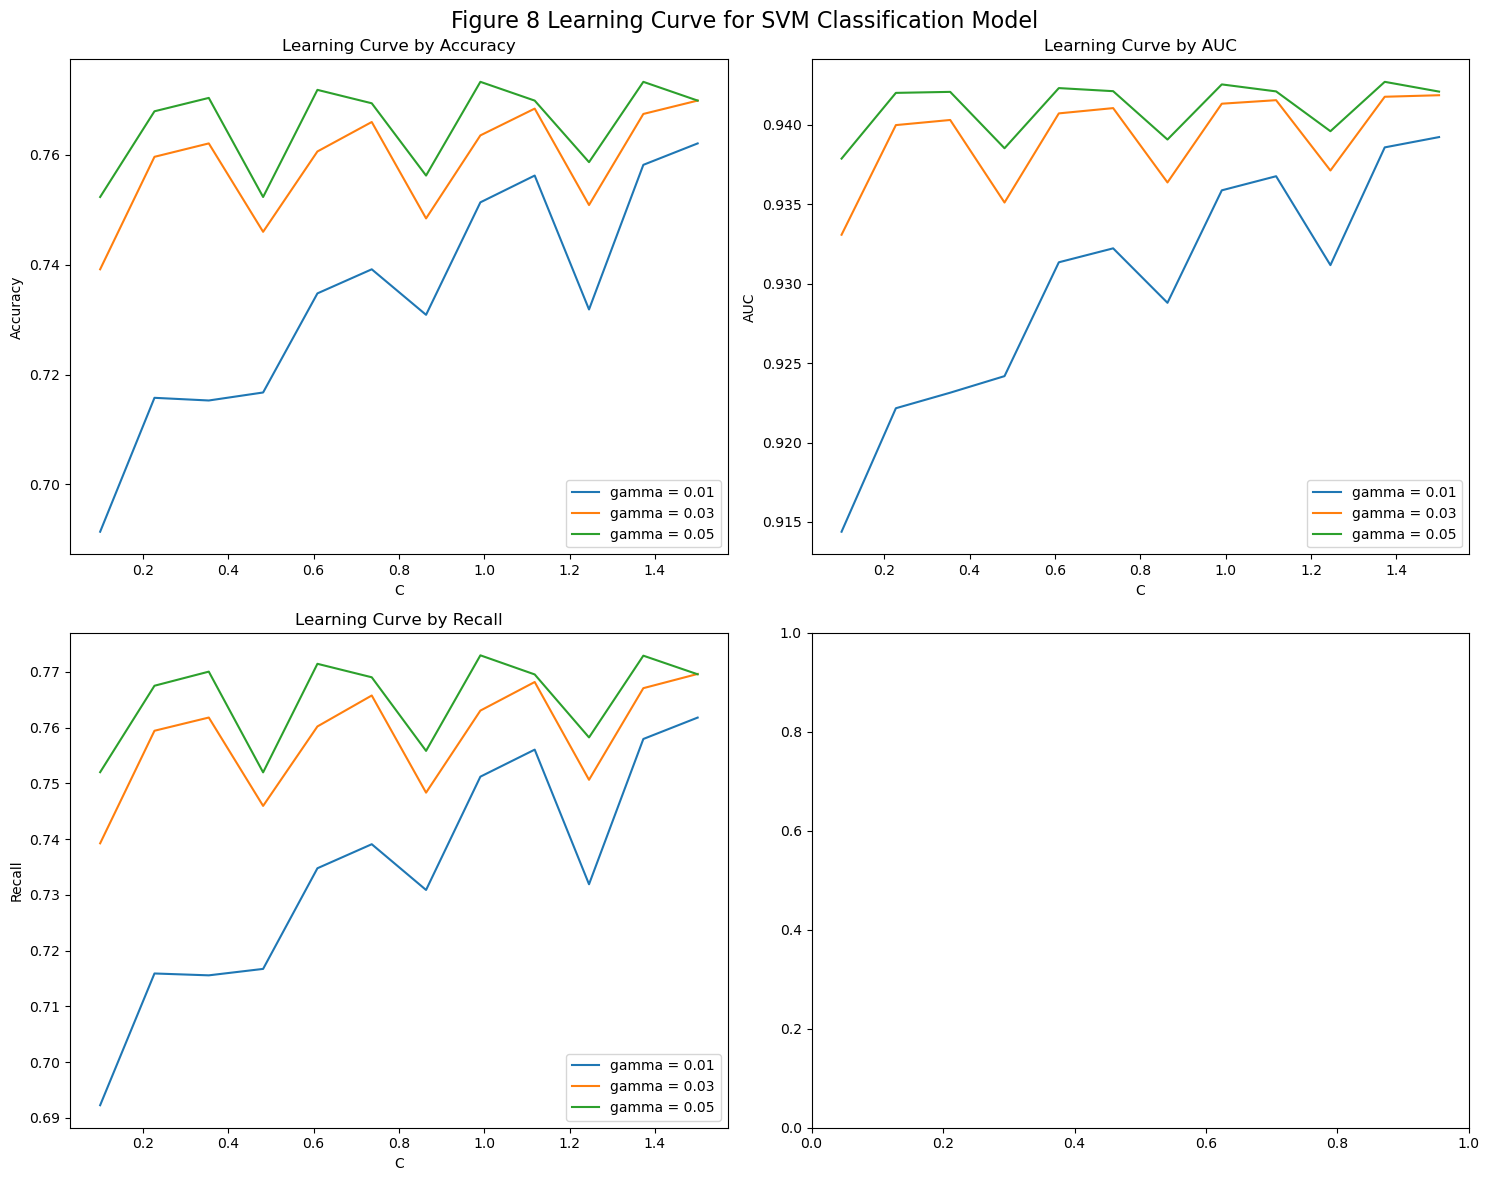

0.7732869264425094 0.7729803114782187 0.9427113604393246


In [15]:
# Extract results
n_estimators_values = parameters['C']
max_depth_values = parameters['gamma']

results_acc = GS_acc.cv_results_
mean_acc = results_acc['mean_test_score']

results_recall = GS_recall.cv_results_
mean_recall = results_recall['mean_test_score']

results_roc = GS_roc.cv_results_
mean_roc = results_roc['mean_test_score']

#Reshape mean_mae to a 2D array for plotting
mean_acc = mean_acc.reshape(len(max_depth_values), len(n_estimators_values))
mean_recall = mean_recall.reshape(len(max_depth_values), len(n_estimators_values))
mean_roc = mean_roc.reshape(len(max_depth_values), len(n_estimators_values))

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Figure 8 Learning Curve for SVM Classification Model", fontsize=16)
# Plot the R2 curve
for i, max_depth in enumerate(max_depth_values):
    axs[1,0].plot(n_estimators_values, mean_recall[i], label=f'gamma = {round(max_depth,2)}')
axs[1,0].set_title("Learning Curve by Recall")
axs[1,0].legend()
axs[1,0].set_xlabel("C")
axs[1,0].set_ylabel("Recall")
# Plot the MAE curve
for i, max_depth in enumerate(max_depth_values):
    axs[0,1].plot(n_estimators_values, mean_roc[i], label=f'gamma = {round(max_depth,2)}')
axs[0,1].set_title("Learning Curve by AUC")
axs[0,1].legend()
axs[0,1].set_xlabel("C")
axs[0,1].set_ylabel("AUC")

for i, max_depth in enumerate(max_depth_values):
    axs[0,0].plot(n_estimators_values, mean_acc[i], label=f'gamma = {round(max_depth,2)}')
axs[0,0].set_title("Learning Curve by Accuracy")
axs[0,0].legend()
axs[0,0].set_xlabel("C")
axs[0,0].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

print(np.max(mean_acc),np.max(mean_recall),np.max(mean_roc))

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

#parameters = {'kernel':["linear","poly","rbf","sigmoid"]
 #             }
parameters = {'kernel':["rbf"]
             ,'gamma':[0.03]
             ,'C':[1.373]}
SVM = SVC(cache_size=9000,probability=True)
GS_acc = GridSearchCV(SVM, parameters, cv=kf, scoring="accuracy")
GS_acc.fit(Xtrain_lr, Ytrain_tree)
GS_recall = GridSearchCV(SVM, parameters, cv=kf, scoring="recall_macro")
GS_recall.fit(Xtrain_lr, Ytrain_tree)
GS_roc = GridSearchCV(SVM, parameters, cv=kf, scoring="roc_auc_ovr")
GS_roc.fit(Xtrain_lr, Ytrain_tree)

 

print(GS_acc.best_score_)
print(GS_recall.best_score_)
print(GS_roc.best_score_)
GS_acc.get_params

0.7766874369473621
0.7764162572081468
0.943480994398978


In [38]:
GS_acc.cv_results_
GS_recall.cv_results_
GS_roc.cv_results_

{'mean_fit_time': array([1.75579691]),
 'std_fit_time': array([0.08456891]),
 'mean_score_time': array([0.09539371]),
 'std_score_time': array([0.00902316]),
 'param_C': masked_array(data=[1.373],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.03],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1.373, 'gamma': 0.03, 'kernel': 'rbf'}],
 'split0_test_score': array([0.95097175]),
 'split1_test_score': array([0.93392383]),
 'split2_test_score': array([0.94027566]),
 'split3_test_score': array([0.93963956]),
 'split4_test_score': array([0.95259416]),
 'mean_test_score': array([0.94348099]),
 'std_test_score': array([0.00714886]),
 'rank_test_score': array([1])}

In [25]:

clf =SVC(kernel="rbf",C=1.373,gamma = 0.03,probability=True).fit(Xtrain_lr,Ytrain_tree)
clf.predict(Xtest_lr)

#print(clf.score(Xtest_lr,Ytest_tree))
# print(clf.support_vectors_.shape)
# print(clf.n_support_)

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

# Step 2: Make predictions on Xtest_lr
predictions = clf.predict(Xtest_lr)
prob = clf.predict_proba(Xtest_lr)
# Step 3: Calculate accuracy
accuracy = accuracy_score(Ytest_tree, predictions)

# Step 4: Calculate recall
recall = recall_score(Ytest_tree, predictions, average='macro')  # 'macro' for multiclass classification

# Step 5: Calculate AUC
# Since SVC does not directly provide probability estimates, we can use decision_function instead of predict_proba
# to calculate the AUC.
decision_values = clf.decision_function(Xtest_lr)
auc = roc_auc_score(Ytest_tree, prob, multi_class='ovr')

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("AUC:", auc)

Accuracy: 0.7792946530147895
Recall: 0.7791558823496112
AUC: 0.9521349151037295


In [27]:
clf =SVC(kernel="rbf",C=1.373,gamma = 0.03,probability=True).fit(Xtrain_lr,Ytrain_tree)

Xtest_lr = Xtrain_lr
Ytest_tree = Ytrain_tree
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

# Step 2: Make predictions on Xtest_lr
predictions = clf.predict(Xtest_lr)
prob = clf.predict_proba(Xtest_lr)
# Step 3: Calculate accuracy
accuracy = accuracy_score(Ytest_tree, predictions)

# Step 4: Calculate recall
recall = recall_score(Ytest_tree, predictions, average='macro')  # 'macro' for multiclass classification

# Step 5: Calculate AUC
# Since SVC does not directly provide probability estimates, we can use decision_function instead of predict_proba
# to calculate the AUC.
decision_values = clf.decision_function(Xtest_lr)
auc = roc_auc_score(Ytest_tree, prob, multi_class='ovr')

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("AUC:", auc)

Accuracy: 0.8571428571428571
Recall: 0.8571792666510918
AUC: 0.9754585368904397
